In [29]:
import numpy as np
import torch
import gif
import matplotlib.pyplot as plt
import pytorch_lightning as pl 
from pathlib import Path
import yaml
import matplotlib.ticker as ticker
import matplotlib.colors as colors

from matplotlib.tri import Triangulation as triang

from scipy.io import loadmat

from scipy.interpolate import LinearNDInterpolator as interp_lin
from core.utils import load_checkpoint

import seaborn

seaborn.set_style("darkgrid")

In [30]:
model_checkpoint_path = Path(r'C:\Users\Kevin\OneDrive - UCB-O365\Documents\Research\QuadConv\lightning_logs\present_qcae_pool\version_4')
data_path = Path(r'C:\Users\Kevin\OneDrive - UCB-O365\Documents\Research\QuadConv\data\ignition_mesh')
model, dataset, locations = load_checkpoint(model_checkpoint_path, data_path)

In [31]:
save_path = model_checkpoint_path

processed_data = model(dataset).detach().numpy()

difference_norm = torch.sqrt((dataset - processed_data)**2)

relative_difference_norm = difference_norm / torch.sqrt((dataset)**2)

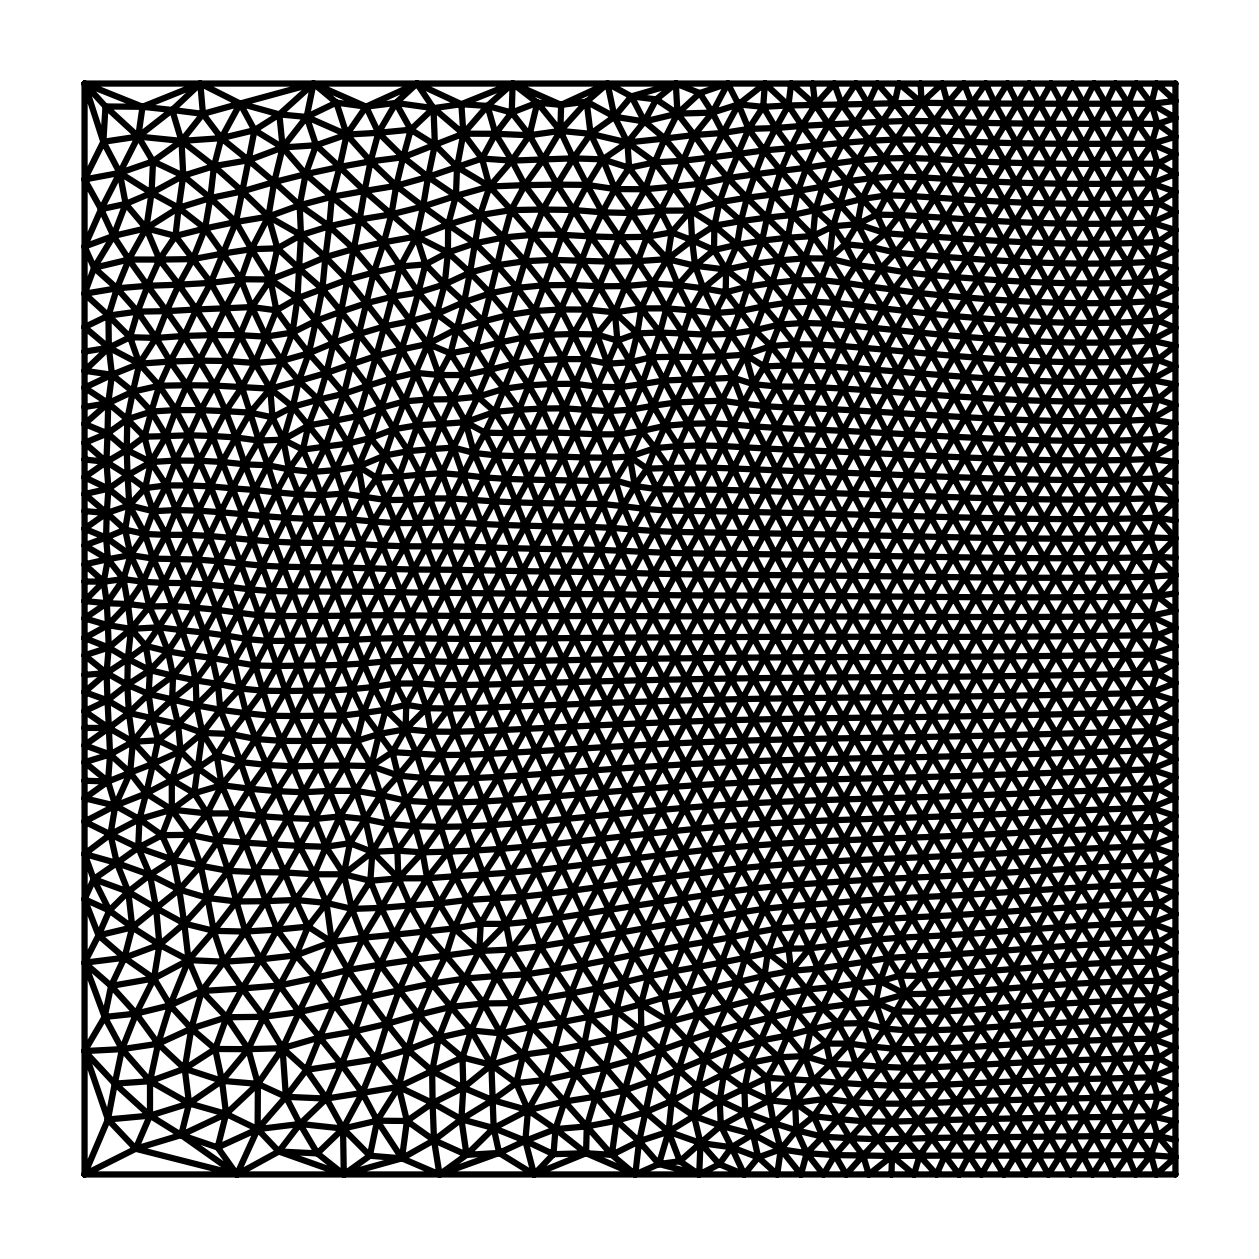

In [6]:

#mesh_scatter = axs[1,0].scatter(locations[:,0], locations[:,1], c = 'black', marker='.', s = 1)
#axs[1,0].set_aspect('equal')

flow_tri = triang(locations[:,0], locations[:,1])

fig_tri = plt.figure(figsize=(4,4), dpi=300)

ax_tri = fig_tri.add_axes([0,0,1,1])

ax_tri.triplot(flow_tri, color='black')

ax_tri.axis('off')

fig_tri.savefig(save_path / 'ignition_mesh.pdf', format='pdf')


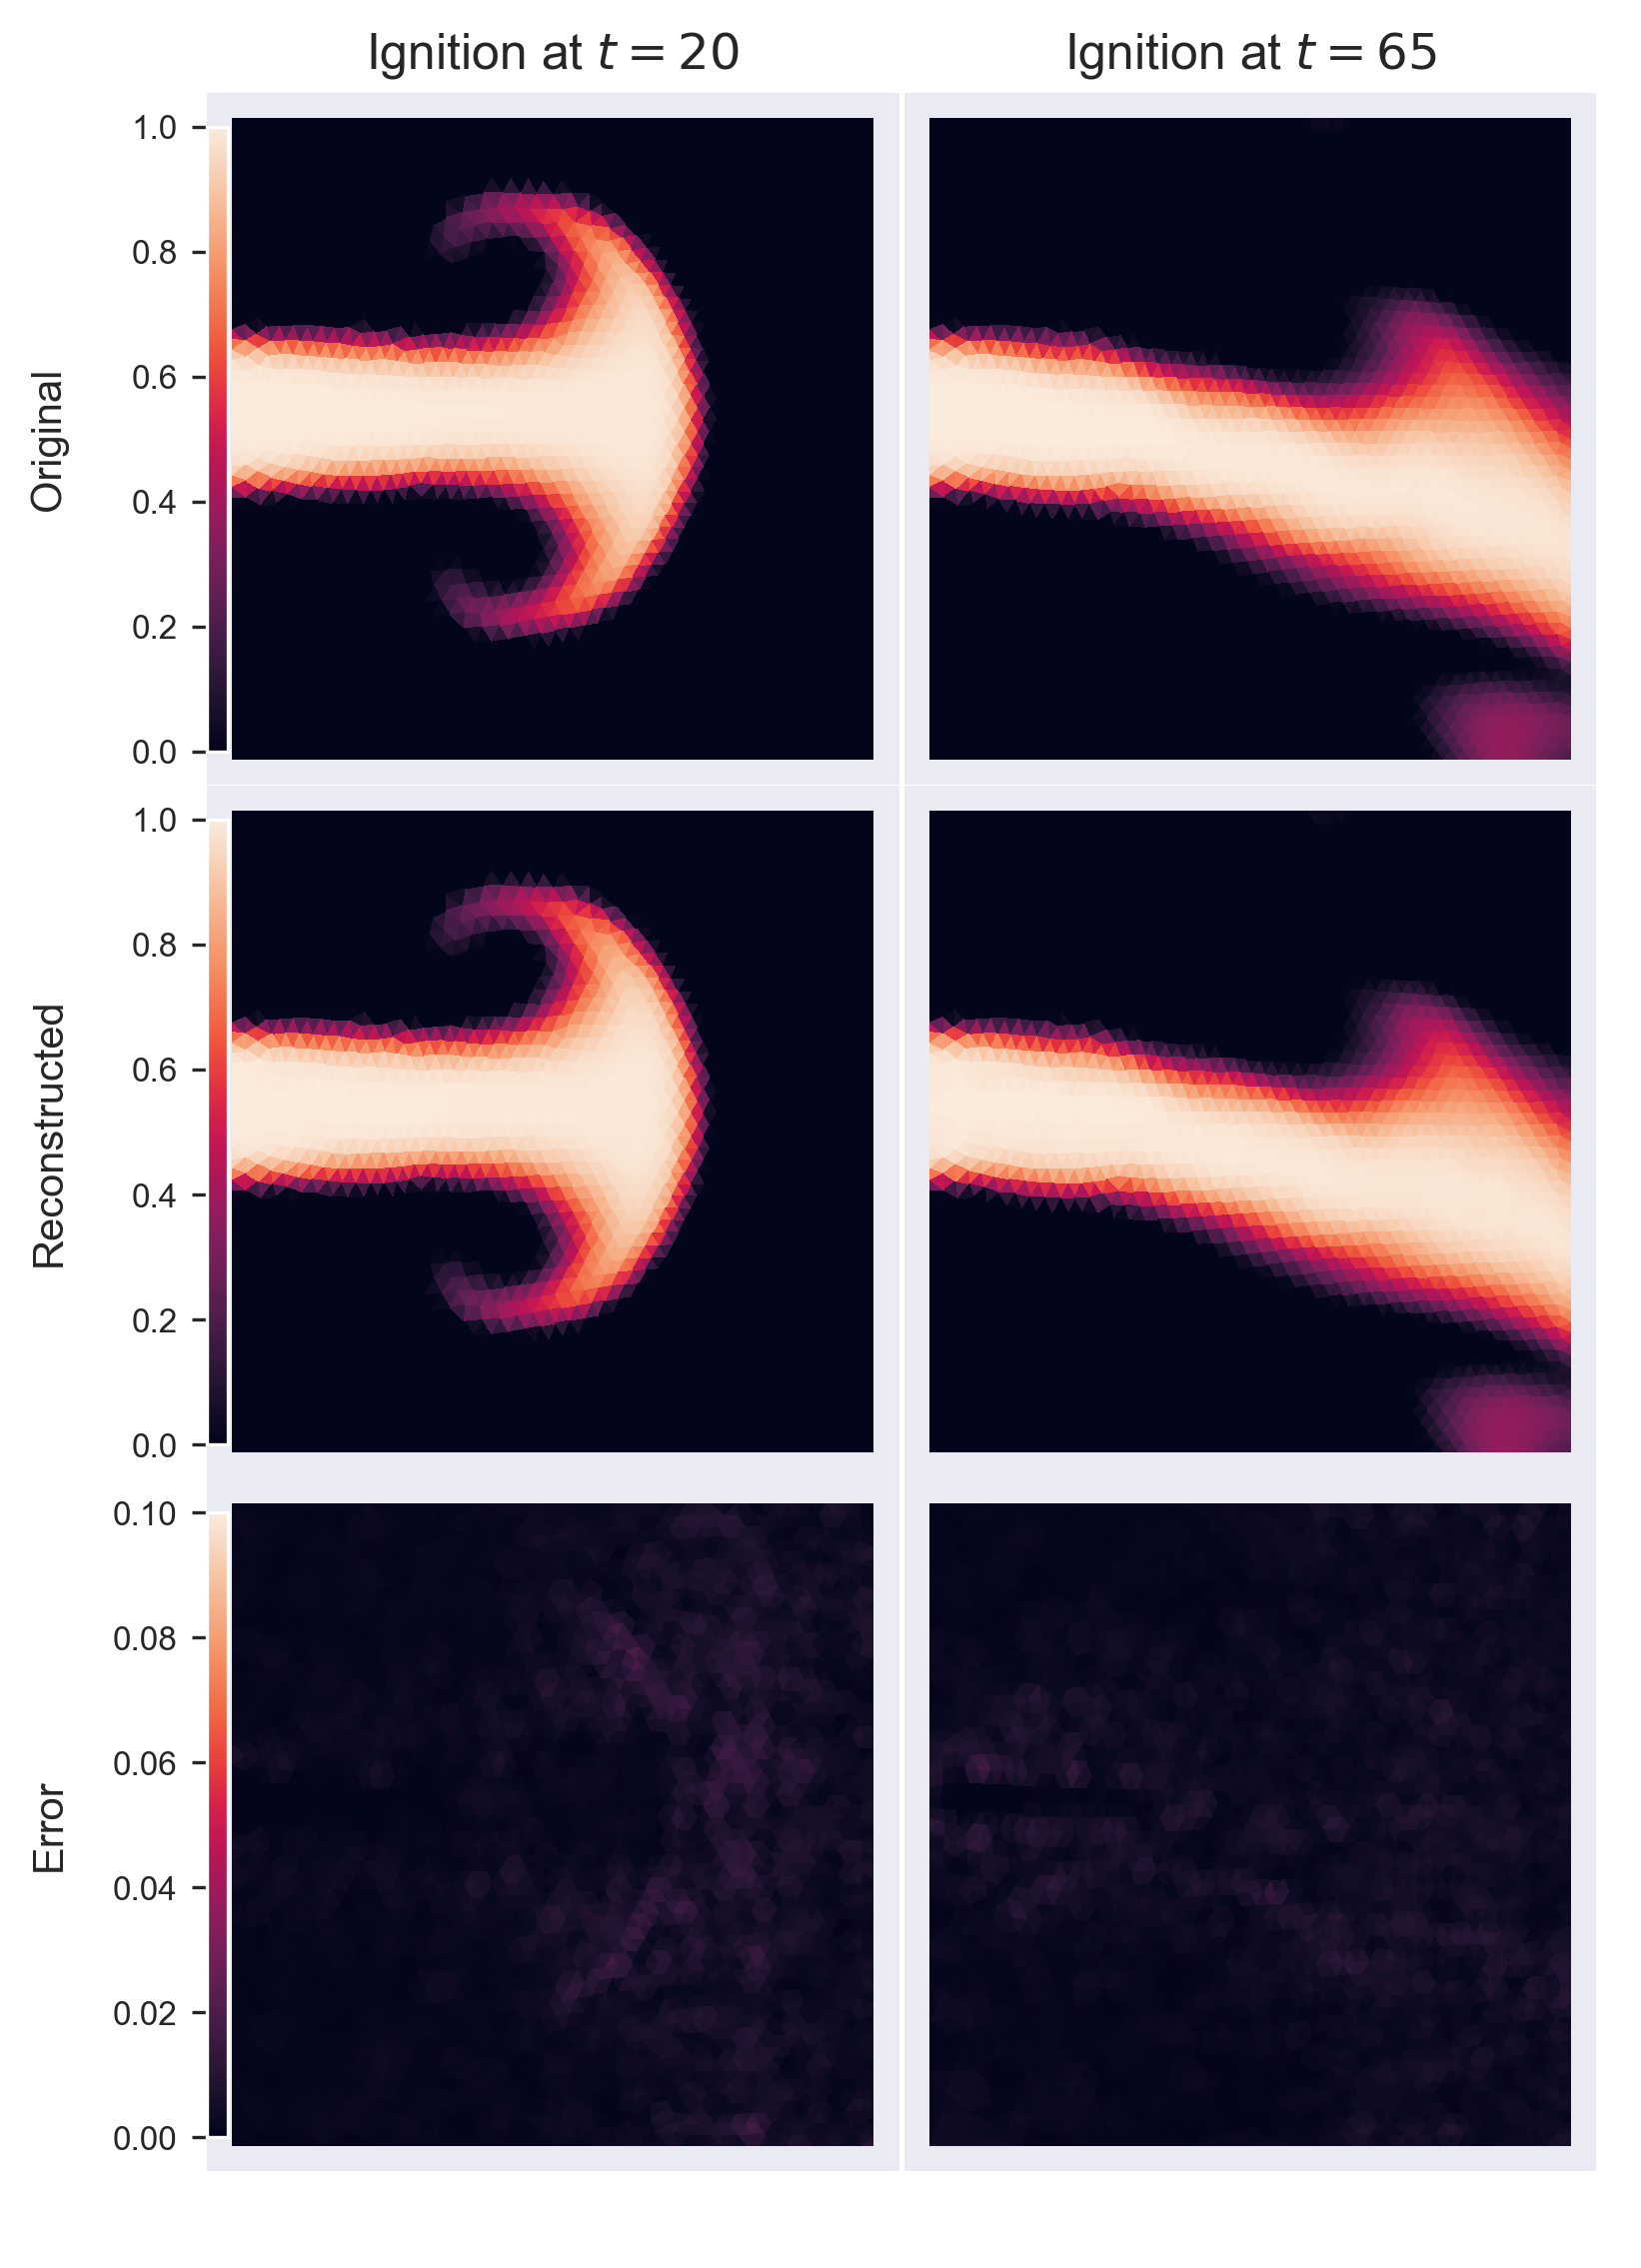

In [11]:
time_steps = [20 , 65]

max_disp = torch.max(dataset)
min_disp = torch.min(dataset)

max_disp = 1
min_disp = 0

my_map = seaborn.color_palette(palette='rocket', as_cmap=True)


fig = plt.figure(figsize=(6,9), dpi=300)

axs = [fig.add_subplot(3,2,i+1) for i in range(6)]

#mesh_scatter = axs[1,0].scatter(locations[:,0], locations[:,1], c = 'black', marker='.', s = 1)
#axs[1,0].set_aspect('equal')

max_x = torch.max(locations[:,0])
max_y = torch.max(locations[:,1])

flow_tri = triang(locations[:,0], locations[:,1])

#mask = np.full((14806,), True)
#print(flow_tri.get_masked_triangles().shape)
#flow_tri = flow_tri.set_mask(mask)

map_it0 = axs[0].tripcolor(flow_tri, dataset[time_steps[0],0,:], facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

map_it2 = axs[2].tripcolor(flow_tri, processed_data[time_steps[0],0,:], facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

map_it4 = axs[4].tripcolor(flow_tri, difference_norm[time_steps[0],0,:], facecolors=None, shading='flat', vmin=0, vmax=0.1, cmap= my_map)

axs[1].tripcolor(flow_tri, dataset[time_steps[1],0,:], facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

axs[3].tripcolor(flow_tri, processed_data[time_steps[1],0,:], facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

axs[5].tripcolor(flow_tri, difference_norm[time_steps[1],0,:], facecolors=None, shading='flat', vmin=0, vmax=0.1, cmap= my_map)

# Tweak all the axes 
for ax in axs:
    ax.label_outer()
    ax.set_aspect('equal')
    ax.margins(x=0.04, y = 0.04)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    #ax.set_axis_off()   

plt.subplots_adjust(hspace = 0.001, wspace = 0.001)

#axs[1].set_axis_off()   
#axs[3].set_axis_off()   
#axs[5].set_axis_off()   

# Make colorbars 
bbox = axs[0].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0] -0.00, pos[1] + 0.0125 , pos[2]*0.03, pos[3] - 0.025])
plt.colorbar(map_it0, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[2].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0]-0.000, pos[1] + 0.0125, pos[2]*0.03, pos[3] - 0.025])
plt.colorbar(map_it2, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[4].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0]+0.00, pos[1] + 0.0125, pos[2]*0.03, pos[3] - 0.025])
plt.colorbar(map_it4, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)



axs[0].set_title(r'Ignition at $t=20$')

axs[1].set_title(r'Ignition at $t=65$')


axs[0].yaxis.set_label_coords(-0.2,0.5)
axs[0].set_ylabel('Original')
axs[2].yaxis.set_label_coords(-0.2,0.5)
axs[2].set_ylabel('Reconstructed')
axs[4].yaxis.set_label_coords(-0.2,0.5)
axs[4].set_ylabel('Error')


fig.savefig(save_path / 'ignition_viz_results.png', format='png', dpi=300, transparent=True, bbox_inches='tight')


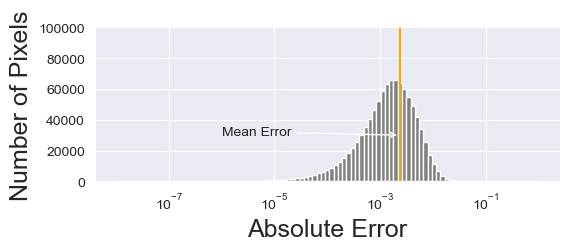

In [9]:

fig = plt.figure(figsize=(6,2))
ax = fig.add_subplot(1,1,1)

ax.hist(difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=False, color='grey')
ax.set_xscale("log")
plt.ylabel('Number of Pixels', fontsize=18)
plt.xlabel('Absolute Error', fontsize=18)

ax.axvline(x = torch.mean(difference_norm), color = 'orange', label = 'Mean Error')
ax.annotate('Mean Error' , (torch.mean(difference_norm),3e4), xytext=(1e-6, 3e4), textcoords='data', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))


plt.ylim(0,100000)
plt.savefig(save_path / 'ignition_abs_error_histogram.png', format='png', dpi=300, transparent=True, bbox_inches='tight')


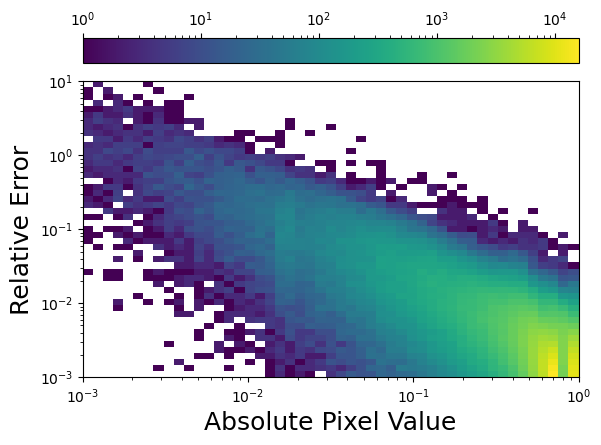

In [53]:
xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

plt.hist2d( torch.abs(dataset.flatten()).numpy(), relative_difference_norm.flatten().numpy(), bins=[xbin,ybin], norm = colors.LogNorm())

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.colorbar(location='top')
plt.xlabel('Absolute Pixel Value', fontsize=18)
plt.ylabel('Relative Error', fontsize=18)

plt.savefig(save_path / 'ignition_abs_rel_histogram.pdf', format='pdf')

<Figure size 640x480 with 0 Axes>

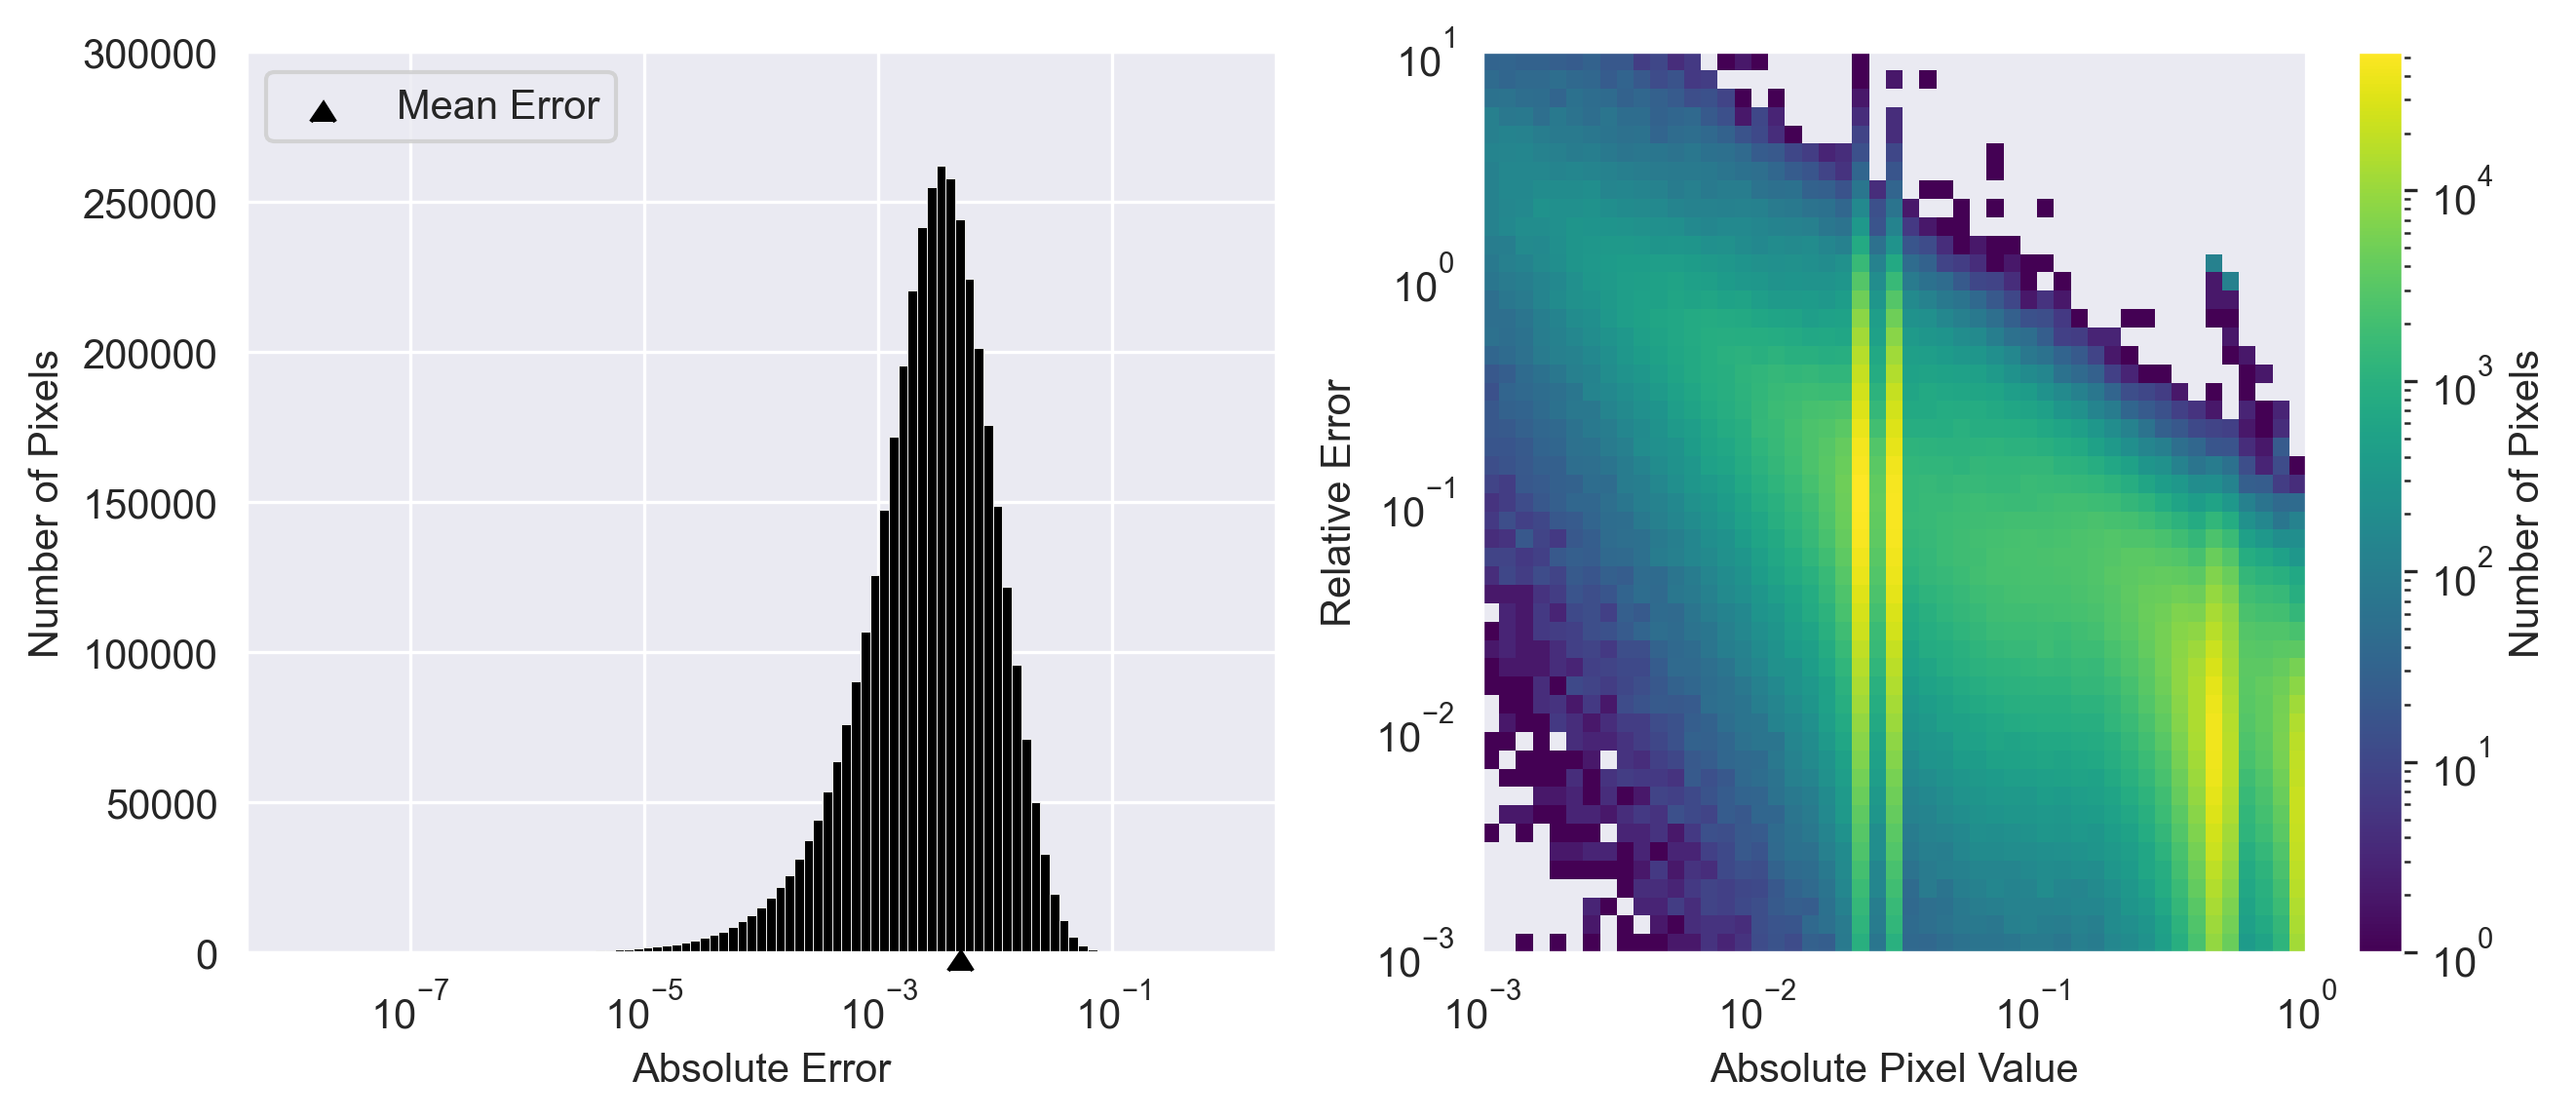

In [32]:
# subplot version of histograms

plt.subplots_adjust(hspace = 0.1, wspace = 0.01)

fig = plt.figure(figsize=(10,4), dpi=300)

haxs = [fig.add_subplot(1,2,i+1) for i in range(2)]

haxs[0].hist(difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=False, color='black', linewidth=0.2)
haxs[0].set_xscale("log")
haxs[0].set(xlabel="Absolute Error",ylabel="Number of Pixels")
haxs[0].set_ylim(0,300000)

mean_mark = haxs[0].plot(torch.mean(difference_norm), 0, color = 'black', marker=6,label = 'Mean Error', zorder=10, clip_on=False, linestyle="None")

haxs[0].legend(loc='upper left')

hist_map = seaborn.color_palette(palette='viridis', as_cmap=True)

xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

h2 = haxs[1].hist2d( torch.abs(dataset.flatten()).numpy(), relative_difference_norm.flatten().numpy(), bins=[xbin,ybin], norm = colors.LogNorm(), cmap=hist_map)

haxs[1].set_xscale("log")
haxs[1].set_yscale("log")
haxs[1].set(xlabel="Absolute Pixel Value",ylabel="Relative Error")

fig.colorbar(h2[3], ax=haxs[1], location='right', label = 'Number of Pixels')

plt.savefig(save_path / 'error_analysis_plots_ignition_unstructured.png', format='png', dpi=300, bbox_inches='tight')

In [25]:
# print relevant numbers

print(sum(p.numel() for p in model.parameters() if p.requires_grad))


#compute average relative reconstruction error
dim = tuple([i for i in range(1, 3)])

n = torch.sqrt(torch.sum((dataset-processed_data)**2, dim=dim))
d = torch.sqrt(torch.sum((dataset)**2, dim=dim))

print(dim)
print(torch.mean(n/d))

print(dataset.shape)
print(n.shape)

340265
(1, 2)
tensor(0.0195)
torch.Size([450, 4, 2189])
torch.Size([450])
